In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm
from geopy.distance import geodesic
from quetzal.model import stepmodel
from quetzal.analysis import analysis

In C:\Users\marlin.arnz\AppData\Local\Continuum\miniconda3\envs\quetzal\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\marlin.arnz\AppData\Local\Continuum\miniconda3\envs\quetzal\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\marlin.arnz\AppData\Local\Continuum\miniconda3\envs\quetzal\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In C:\Users\marlin.arnz\AppData\Local\Continuum\miniconda3\envs\quetzal\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The validate_bool_maybe_none func

# Preparation of the LoS tables
## Saves a StepModel with shortest paths and LoS attributes for the PT network
## Needs aggregated PT networks

In [2]:
input_path = '../input/'
output_path = '../output/'
model_path = '../model/'

In [3]:
sm = stepmodel.read_json(model_path + 'de_pt_network_agg')
ae = stepmodel.read_json(model_path + 'de_pt_access_egress')

In [4]:
sm.centroids = ae.centroids
sm.footpaths = ae.footpaths
sm.zone_to_transit = ae.zone_to_transit

### Prepare links for pathfinder

In [5]:
# Generate length for PT links as the crow flies
if 'length' not in sm.links.columns:
    tqdm.pandas()
    sm.links['length'] = sm.links['geometry'].progress_apply(
        lambda l: int(geodesic(l.coords[0], l.coords[-1]).m))

In [6]:
# Add average waiting time (half the headway) on links
if True:#'headway' not in sm.links.columns:
    sm.links['headway'] = 10*60*2
    # Air trips require security checks and so on...
    sm.links.loc[sm.links['route_type']=='air', 'headway'] = 45*60*2

In [7]:
sm.links.sample()

,a,b,route_type,geometry,link_sequence,route_id,time,trip_id,length,headway,price
index,,,,,,,,,,,
bus_620401,bus_n_305256,bus_n_37496,bus,"LINESTRING (8.96886 53.49804, 9.03429 53.49401)",1,bus_18331,420,bus_104355,7250,0,0.0


In [8]:
assert not sm.footpaths.empty, 'Footpaths must be defined in a previous step'

In [9]:
# Load OD pairs from volumes if available
od_set = None
try:
    v = stepmodel.read_json(model_path + 'de_volumes')
    od_set = set([tuple(l) for l in v.volumes[['origin', 'destination']].values.tolist()])
    print('Generated OD set with {} pairs'.format(len(od_set)))
except:
    print('The volumes file is not (yet) available')

Generated OD set with 155236 pairs


### Apply PT pathfinder
It generates the LoS table with shortest paths for each origin destination pair

In [10]:
'''This cell would run all possible mode combinations
sm.step_pt_pathfinder(
    broken_routes=False,
    broken_modes=True, # Allow different mode combinations
    route_column='route_id',
    mode_column='route_type',
    boarding_time=0, # Assumption
    alighting_time=0,
    speedup=True,
    walk_on_road=False,
    keep_pathfinder=False, # Saves it as attribute for multiple iterations
    force=False, # If indices are inconsistent
    path_analysis=True, # Create path, time and length columns
    drop_duplicates=True, # Considering duplicate paths
    cutoff=np.inf, # distance limit between points for Dijkstra algorithm
    od_set=od_set) # Exclude OD pairs that are not used'''

"This cell would run all possible mode combinations\nsm.step_pt_pathfinder(\n    broken_routes=False,\n    broken_modes=True, # Allow different mode combinations\n    route_column='route_id',\n    mode_column='route_type',\n    boarding_time=0, # Assumption\n    alighting_time=0,\n    speedup=True,\n    walk_on_road=False,\n    keep_pathfinder=False, # Saves it as attribute for multiple iterations\n    force=False, # If indices are inconsistent\n    path_analysis=True, # Create path, time and length columns\n    drop_duplicates=True, # Considering duplicate paths\n    cutoff=np.inf, # distance limit between points for Dijkstra algorithm\n    od_set=od_set) # Exclude OD pairs that are not used"

In [11]:
# We don't want the algorithm to search paths for all mode combinations.
# Thus, we have to extract the pathfinder and search them manually.
# This step yields shortest paths regardless of the mode combination.
sm.step_pt_pathfinder(
    broken_routes=False,
    broken_modes=False,
    keep_pathfinder=True, # get the PPF
    mode_column='route_type',
    route_column='route_id',
    speedup=True,
    cutoff=np.inf,
    walk_on_road=False,
    od_set=od_set,
    path_analysis=False,
)
ppf = sm.publicpathfinder

In [12]:
len(sm.pt_los)

153275

In [13]:
# Now, build custom mode combinations
# People just don't go by coach and then switch to rail or airplane within Germany
ppf.build_mode_combinations(mode_column='route_type')
ppf.mode_combinations = [x for x in ppf.mode_combinations
                         if not ('coach' in x and
                         ('rail_long_distance' in x or
                          'rail_short_distance' in x or
                          'air' in x))]
ppf.mode_combinations

[{'air', 'bus', 'rail_long_distance', 'rail_short_distance'},
 {'air', 'bus', 'rail_long_distance'},
 {'air', 'bus', 'rail_short_distance'},
 {'air', 'bus'},
 {'air', 'rail_long_distance', 'rail_short_distance'},
 {'air', 'rail_long_distance'},
 {'air', 'rail_short_distance'},
 {'air'},
 {'bus', 'coach'},
 {'bus', 'rail_long_distance', 'rail_short_distance'},
 {'bus', 'rail_long_distance'},
 {'bus', 'rail_short_distance'},
 {'bus'},
 {'coach'},
 {'rail_long_distance', 'rail_short_distance'},
 {'rail_long_distance'},
 {'rail_short_distance'},
 set()]

In [14]:
# Run the pathfinder for all mode combinations
ppf.find_broken_mode_paths(workers=3, # CPU cores
                           cutoff=np.inf,
                           od_set=od_set,
                           mode_column='route_type')

breaking modes: set() : 100%|██████████████████████████████████████████████████████████████| 18/18 [31:50<00:00, 106.15s/it]


In [15]:
ppf.broken_mode_paths.sample()

,origin,destination,gtime,path,reversed,pathfinder_session,broken_modes
142010,DEE0D,DE21D,15115.235294,"[DEE0D, bus_n_104139, bus_1413574, bus_n_10526...",False,mode_breaker,{rail_long_distance}


In [16]:
# Run the path analysis and assign paths as LoS table
sm.pt_los = analysis.path_analysis_od_matrix(
    od_matrix=ppf.broken_mode_paths,
    links=sm.links,
    nodes=sm.nodes,
    centroids=sm.centroids)

path_analysis: 100%|████████████████████████████████████████████████████████████| 2343902/2343902 [09:56<00:00, 3932.27it/s]


In [17]:
print(len(sm.pt_los.index))
sm.pt_los.loc[sm.pt_los['origin']!=sm.pt_los['destination']].sample(3)

2343902


,origin,destination,gtime,path,reversed,pathfinder_session,broken_modes,boardings,alightings,node_path,link_path,footpaths,ntlegs,transfers,boarding_links,alighting_links,all_walk,ntransfers,time_link_path,length_link_path
123489,DEB35,DEG05,10744.611765,"[DEB35, rail_long_node_10, rail_short_node_694...",False,mode_breaker,"{bus, air}","[rail_short_node_6947, rail_short_node_10704, ...","[rail_short_node_10704, rail_short_node_12047,...","[rail_long_node_10, rail_short_node_6947, rail...","[rail_short_43407, rail_short_113219, rail_sho...","[(rail_long_node_10, rail_short_node_6947), (r...","[(DEB35, rail_long_node_10), (rail_long_node_1...","[rail_short_node_10704, rail_short_node_12047,...","[rail_short_43407, rail_short_113219, rail_sho...","[rail_short_43407, rail_short_113219, rail_sho...",False,7,9660,359438
17869,DE211,DE942,26504.011765,"[DE211, bus_n_335645, bus_1470827, bus_n_33369...",False,mode_breaker,"{rail_long_distance, rail_short_distance, air}","[bus_n_335645, bus_n_333698, coach_node_FLIXBU...","[bus_n_333698, bus_n_192200, coach_node_FLIXBU...","[bus_n_335645, bus_n_333698, bus_n_192200, coa...","[bus_1470827, bus_385502, coach_12831, coach_5...","[(bus_n_192200, coach_node_FLIXBUS:19698), (co...","[(DE211, bus_n_335645), (coach_node_FLIXBUS:73...","[bus_n_333698, coach_node_FLIXBUS:21, coach_no...","[bus_1470827, bus_385502, coach_12831, coach_5...","[bus_1470827, bus_385502, coach_12831, coach_5...",False,83,24000,1120665
146420,DEF0A,DE21C,36196.152941,"[DEF0A, rail_short_node_8960, rail_short_16893...",False,mode_breaker,"{bus, rail_long_distance, air}","[rail_short_node_8960, rail_short_node_11885, ...","[rail_short_node_11885, rail_short_node_6462, ...","[rail_short_node_8960, rail_short_node_11885, ...","[rail_short_16893, rail_short_16894, rail_shor...","[(rail_short_node_6462, rail_long_node_353), (...","[(DEF0A, rail_short_node_8960), (rail_short_no...","[rail_short_node_11885, rail_short_node_9605, ...","[rail_short_16893, rail_short_56689, rail_shor...","[rail_short_16895, rail_short_56690, rail_shor...",False,45,32880,1005139


### Add attributes to LoS table

In [18]:
# Disaggregate time into in-vehicle and access/egress
sm.analysis_pt_time(boarding_time=0)
print(sm.pt_los.columns)

Index(['origin', 'destination', 'gtime', 'path', 'reversed',
       'pathfinder_session', 'broken_modes', 'boardings', 'alightings',
       'node_path', 'link_path', 'footpaths', 'ntlegs', 'transfers',
       'boarding_links', 'alighting_links', 'all_walk', 'ntransfers',
       'time_link_path', 'length_link_path', 'access_time', 'footpath_time',
       'in_vehicle_time', 'waiting_time', 'boarding_time', 'time'],
      dtype='object')


In [19]:
# Add price, parametrisation comes later
sm.pt_los['price'] = 0

In [20]:
# Add distances
len_dict = sm.links['length'].to_dict()
sm.pt_los['length'] = sm.pt_los['link_path'].apply(lambda p: sum([len_dict[l] for l in p]))

In [21]:
# Add route_types
type_dict = sm.links['route_type'].to_dict()
sm.pt_los['route_types'] = [set([type_dict[link] for link in l])
                            for l in list(sm.pt_los['link_path'])]

In [22]:
# Add main route_type based on a hierarchy
hierarchy = ['air', 'coach', 'rail_long_distance', 'rail_short_distance', 'bus', 'walk']
def main_type(types):
    t = hierarchy[-1]
    try:
        t = hierarchy[min([hierarchy.index(t) for t in types])]
    except ValueError: # empty types set
        pass
    return t
sm.pt_los['route_type'] = sm.pt_los['route_types'].apply(main_type)

In [23]:
# Add number of transfers
#sm.pt_los['ntransfers'] = sm.pt_los['boardings'].apply(lambda l: max(0, len(l) - 1))

In [24]:
sm.pt_los.sample(2)

,origin,destination,gtime,path,reversed,pathfinder_session,broken_modes,boardings,alightings,node_path,...,access_time,footpath_time,in_vehicle_time,waiting_time,boarding_time,time,price,length,route_types,route_type
49532,DE26A,DE926,7997.352941,"[DE26A, bus_n_329102, bus_277242, bus_n_88420,...",False,mode_breaker,{coach},"[bus_n_329102, bus_n_364847, bus_n_256966, rai...","[bus_n_88420, bus_n_256966, bus_n_247332, rail...","[bus_n_329102, bus_n_88420, rail_short_node_13...",...,654.352941,743,6600,0.0,0,7997.352941,0,364667,"{bus, rail_short_distance, rail_long_distance}",rail_long_distance
65326,DE711,DEF02,23386.294118,"[DE711, rail_short_node_2, bus_n_21457, bus_16...",False,mode_breaker,"{rail_long_distance, rail_short_distance, air}","[bus_n_21457, coach_node_FLIXBUS:20648, coach_...","[bus_n_61091, coach_node_FLIXBUS:13, coach_nod...","[rail_short_node_2, bus_n_21457, bus_n_61091, ...",...,437.294118,1289,21660,0.0,0,23386.294118,0,997355,"{bus, coach}",coach


In [25]:
# Make a copy before restricting results
los = sm.pt_los.copy()

### Clean PT LOS

In [41]:
# Drop trips with coach-rail or coach-air combinations
sm.pt_los = sm.pt_los.loc[~sm.pt_los['route_types'].apply(
    lambda x: 'coach' in x and ('rail_long_distance' in x or 'rail_short_distance' in x or 'air' in x))]
sm.pt_los.shape

(1848554, 30)

In [42]:
# Drop unrealistically long trips
sm.pt_los = sm.pt_los.loc[sm.pt_los['in_vehicle_time']<10*3600]
sm.pt_los.shape

(1845527, 30)

array([[<AxesSubplot:title={'center':'time'}>]], dtype=object)

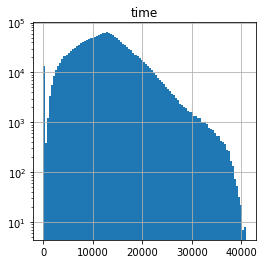

In [43]:
# Time distribution
sm.pt_los.hist(column='time', bins=100, figsize=(4,4), log=True)

In [44]:
'''# Keep only the fastest trip(s)
sm.pt_los['route_types'] = sm.pt_los['route_types'].apply(tuple)
sm.pt_los = sm.pt_los.sort_values('time').groupby(
    ['origin', 'destination', 'route_types']).nth(0)'''
# Drop duplicates
sm.pt_los['path'] = sm.pt_los['path'].apply(tuple)
sm.pt_los.drop_duplicates('path', inplace=True)
sm.pt_los.reset_index(inplace=True)
sm.pt_los.shape

(1742910, 31)

array([[<AxesSubplot:title={'center':'time'}>]], dtype=object)

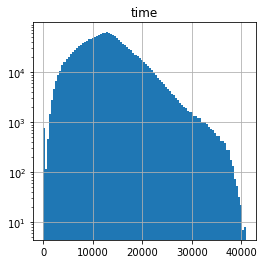

In [45]:
sm.pt_los.hist(column='time', bins=100, figsize=(4,4), log=True)

array([[<AxesSubplot:title={'center':'ntransfers'}>]], dtype=object)

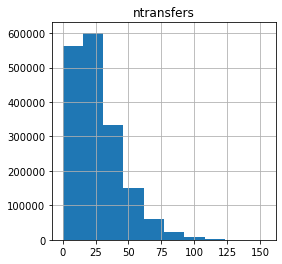

In [46]:
sm.pt_los.hist(column='ntransfers', figsize=(4,4))

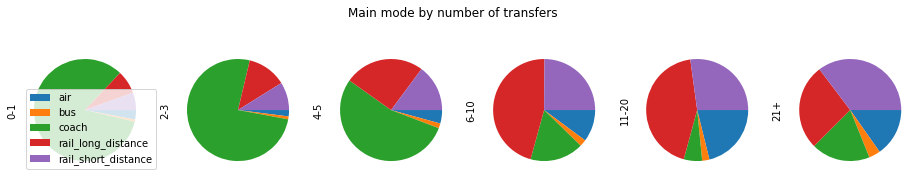

In [47]:
t = sm.pt_los.copy()
t['bins'] = pd.cut(t['ntransfers'], bins=[0,1,3,5,10,20,100],
                   labels=["0-1", "2-3","4-5","6-10","11-20","21+"])
axs = t.groupby(['route_type','bins']).size().unstack(fill_value=0).plot.pie(
    subplots=True, figsize=(16, 3),
    startangle=0, counterclock=False, title='Main mode by number of transfers',
    legend=False, labeldistance=None)
axs[0].legend(loc='lower left')

In [33]:
# Drop unnecessary long connections
if sm.links['headway'].mean() > 60:
    sm.pt_los = sm.pt_los.loc[sm.pt_los['ntransfers']<20]
    print(sm.pt_los.shape)

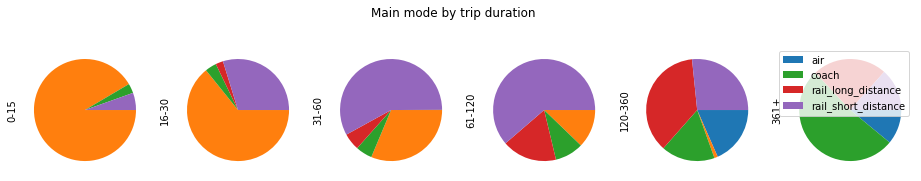

In [48]:
t['time'] = t['time'] / 60
t['bins'] = pd.cut(t['time'], bins=[0,15,30,60,120,360,500],
                   labels=["0-15", "16-30","31-60","61-120","120-360","361+"])
axs = t.groupby(['route_type','bins']).size().unstack(fill_value=0).plot.pie(
    subplots=True, figsize=(16, 3),
    startangle=0, counterclock=False, title='Main mode by trip duration',
    legend=False, labeldistance=None)
axs[-1].legend()

In [49]:
t = None

In [50]:
# Ditch unneccessary columns
to_drop = ['gtime', 'path', 'reversed', 'pathfinder_session',
           'broken_modes', 'boardings', 'alightings', 'node_path',
           'footpaths', 'ntlegs', 'transfers', 'boarding_links',
           'alighting_links', 'all_walk', 'time_link_path',
           'length_link_path', 'boarding_time']
sm.pt_los = sm.pt_los.drop(to_drop, axis=1, errors='ignore')

In [51]:
# Clean links table
to_drop = ['duration', 'cost', 'origin', 'destination']
sm.links = sm.links.drop(to_drop, axis=1, errors='ignore')

In [52]:
# Make table smaller
cols = ['time', 'access_time', 'in_vehicle_time', 'footpath_time',
        'waiting_time', 'length']
sm.pt_los[cols] = sm.pt_los[cols].astype(int)

In [53]:
sm.pt_los.sample()

,index,origin,destination,link_path,ntransfers,access_time,footpath_time,in_vehicle_time,waiting_time,time,price,length,route_types,route_type
879581,131545,DEC06,DE125,"[rail_short_46551, rail_short_46552, rail_shor...",10,529,0,5280,0,5809,0,180282,{rail_short_distance},rail_short_distance


### Save model

In [54]:
# Saving LoS...
sm.to_json(model_path + 'de_pt_los', only_attributes=['pt_los'],
           encoding='utf-8')

to_hdf(overwriting): 100%|██████████████████████████████████████████████████████████████████| 36/36 [02:10<00:00,  3.62s/it]


In [45]:
# Split links in graph and auxiliary information
# for file sizes being compatible with github's size limit
cols = ['link_sequence', 'route_id', 'time', 'trip_id', 'length', 'headway']
auxiliary = sm.links[cols]
sm.links.drop(cols, axis=1, inplace=True)

In [36]:
sm.to_json(model_path + 'de_pt_network_agg', only_attributes=[
    'zones', 'links', 'nodes', 'pt_route_types'],
           encoding='utf-8')

to_hdf(overwriting): 100%|██████████████████████████████████████████████████████████████████| 36/36 [00:57<00:00,  1.59s/it]


In [37]:
# Save auxiliary information seperately
auxiliary['index'] = auxiliary.index
auxiliary.reset_index(drop=True, inplace=True)
auxiliary.to_json(model_path + 'de_pt_network_agg/links_quetzaldata.json')

In [41]:
sm.links = None
sm.nodes = None